# Here is your task
After asking around for the source of the existing data, you learn that the current process is to take a monthly snapshot of prices from a market data provider, which represents the market price of natural gas delivered at the end of each calendar month. This data is available for roughly the next 18 months and is combined with historical prices in a time series database. After gaining access, you are able to download the data in a CSV file.

You should use this monthly snapshot to produce a varying picture of the existing price data, as well as an extrapolation for an extra year, in case the client needs an indicative price for a longer-term storage contract.

Download the monthly natural gas price data. [dataset](https://cdn.theforage.com/vinternships/companyassets/Sj7temL583QAYpHXD/JiwEkbBq8pFwMRYLc/1683142174343/Nat_Gas.csv).

Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.
Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future. 📊



In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [25]:
df = pd.read_csv(r'../data/raw/Nat_Gas.csv')
df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


In [24]:
df.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


In [26]:
df['Dates'] = pd.to_datetime(df['Dates'], format='%m/%d/%y')

In [28]:
print(df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())


Dates     0
Prices    0
dtype: int64
Duplicate rows: 0


In [ ]:
df = df.sort_values(by='Dates') #sorting according to dates to get the correct order of dates
df['Year'] = df['Dates'].dt.year
df['Month'] = df['Dates'].dt.month
df['Day'] = df['Dates'].dt.day
df.head()

,Dates,Prices,Year,Month,Day
0,2020-10-31,10.1,2020,10,31
1,2020-11-30,10.3,2020,11,30
2,2020-12-31,11.0,2020,12,31
3,2021-01-31,10.9,2021,1,31
4,2021-02-28,10.9,2021,2,28


C:\Users\asus\AppData\Local\Temp\ipykernel_18304\992392412.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette="Blues_d")


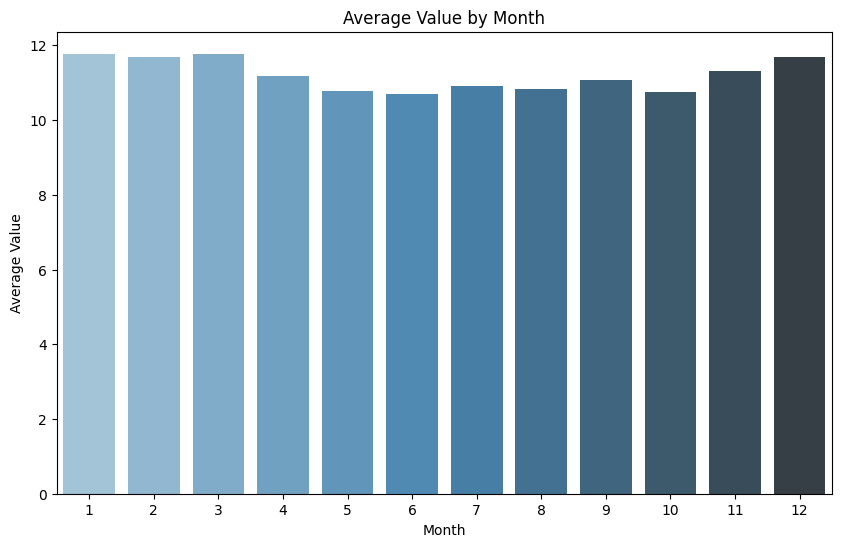

In [35]:
monthly_avg = df.groupby('Month')['Prices'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette="Blues_d")
plt.title("Average Value by Month")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.show()